In [1]:
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200905_cifar"
use_eval_runs = False

In [3]:
if use_eval_runs:
    files = f"../results/{exp_name}/*/eval/*/config.json"
else:
    files = f"../results/{exp_name}/*/config.json"

In [4]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values(["weight_prior", "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x="weight_prior", y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

In [5]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [6]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [7]:
runs_all.head()

,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,cycles,data,device,...,weight_prior_params,weight_scale,width,acc_mean,acc_std,acc_stderr,lp_mean,lp_std,lp_stderr,error_mean
0,128,True,0,gaussian,{},1,10,20,cifar10,try_cuda,...,{},2.41,50,0.137118,0.150907,0.0150907,-3.05676,2.36873,0.0236873,0.862882
1,128,True,0,gaussian,{},1,10,20,cifar10,try_cuda,...,{},0.7,50,0.139002,0.142071,0.0142071,-2.88719,1.27901,0.0127901,0.860998
2,128,True,0,gaussian,{},1,10,20,cifar10,try_cuda,...,{},1.41,50,0.134522,0.137882,0.0137882,-3.1209,1.40621,0.0140621,0.865478
3,128,True,0,gaussian,{},1,10,20,cifar10,try_cuda,...,{},1.41,50,0.117413,0.072859,0.0072859,NaN,NaN,NaN,0.882587
4,128,True,0,gaussian,{},1,10,20,cifar10,try_cuda,...,{},1.41,50,0.118407,0.0795362,0.00795362,NaN,NaN,NaN,0.881593


In [8]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

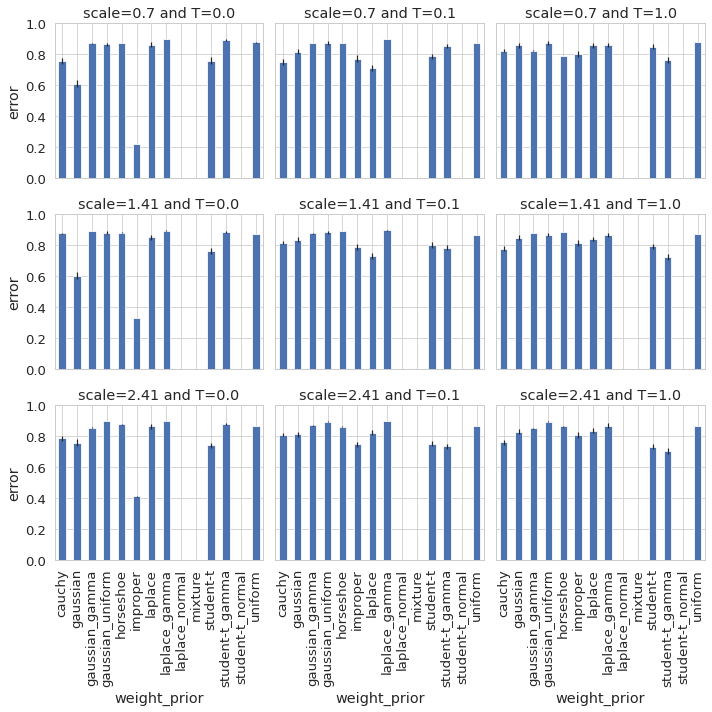

In [9]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 1.))

In [10]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

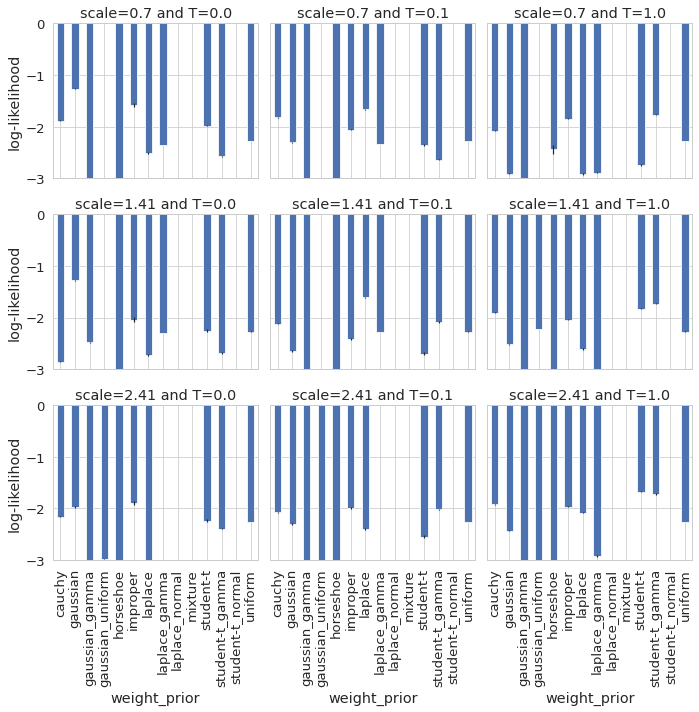

In [11]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-3., 0))

In [12]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [13]:
assert use_eval_runs, "The calibration and OOD can only be assessed on eval data"

AssertionError: The calibration and OOD can only be assessed on eval data

In [ ]:
runs_selected = runs_all.query("eval_data == eval_data")

In [ ]:
for col in runs_selected.columns:
    runs_selected[col] = runs_selected[col].astype(float, errors="ignore")

runs_selected = runs_selected.groupby(by=["weight_prior", "weight_scale", "temperature"]).mean()

runs_selected.reset_index(inplace=True)

In [ ]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.03))

In [ ]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

In [ ]:
fig = plot_grid(runs_selected, y="auroc_mean", yerr="auroc_stderr", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")